<a href="https://colab.research.google.com/github/mvoassis/churn_detection/blob/main/notebooks/Churn_detection_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction - Classification Model
Marcos Oliveira (mvoassis@gmail.com)

Objective - Detect as many Churn clients as possible (prioritize Recall)

## Loading Libs and installing requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install scikit_optimize
!pip install catboost
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.5 MB/s eta 0:00:00


## Loading dataset

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/mvoassis/churn_detection/main/data/data_clean_v5.csv')

data.head()

,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,0,0,0,1,1,9,1,0,DSL,0,1,0,1,1,0,One year,1,Mailed check,65.6,593.30
1,0,1,0,0,0,9,1,1,DSL,0,0,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40
2,1,1,0,0,0,4,1,0,Fiber optic,0,0,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85
3,1,1,1,1,0,13,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85
4,1,0,1,1,0,3,1,0,Fiber optic,0,0,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7032 non-null   int64  
 1   customer_gender            7032 non-null   int64  
 2   customer_SeniorCitizen     7032 non-null   int64  
 3   customer_Partner           7032 non-null   int64  
 4   customer_Dependents        7032 non-null   int64  
 5   customer_tenure            7032 non-null   int64  
 6   phone_PhoneService         7032 non-null   int64  
 7   phone_MultipleLines        7032 non-null   int64  
 8   internet_InternetService   7032 non-null   object 
 9   internet_OnlineSecurity    7032 non-null   int64  
 10  internet_OnlineBackup      7032 non-null   int64  
 11  internet_DeviceProtection  7032 non-null   int64  
 12  internet_TechSupport       7032 non-null   int64  
 13  internet_StreamingTV       7032 non-null   int64

In [5]:
X = data.drop('Churn',axis=1)
y = data['Churn']

In [6]:
y.value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

## Defining saving and loading functions

In [7]:
def save_model(model,name):
    import pickle
    arquivo = name + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved: ',name)

def load_model(name):
    import pickle
    arquivo = name + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

## Setting up the data for the training process

### Separating a test dataset

Before starting the classification model, first the data should be divided into:

* Training set (Cross-validation will divide it into train and validation later)
* Testing set

The testing set should be saved before any balancing/target encoding process, which should be applied only on the training data.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

print('Train: ',X_train.shape[0],'rows (80%)')
print('Test: ',X_test.shape[0],'rows (20%)')

Train:  5625 rows (80%)
Test:  1407 rows (20%)


In [9]:
X_train.shape

(5625, 19)

### Target encoding X_train and X_test based on the train data.

Target encoding is often preferred over one-hot encoding for tree-based classification models due to its ability to capture and exploit the underlying relationships within categorical features more effectively.

In one-hot encoding, each unique category is transformed into a binary feature, resulting in a high-dimensional and sparse dataset. This can lead to increased memory usage and computational overhead. Moreover, tree-based algorithms like decision trees and random forests work by recursively partitioning the feature space, and one-hot encoding can introduce a multitude of binary splits, making the tree complex and prone to overfitting.

Target encoding, on the other hand, encodes categorical features with the mean of the target variable for each category, which encapsulates valuable information about the relationship between the category and the target.

This continuous representation reduces dimensionality, preserves the inherent order, and helps decision trees make more informed and efficient splits, often leading to better predictive performance and more interpretable models.

In [10]:
from category_encoders import TargetEncoder

encoder = TargetEncoder()

# Fitting the encoder to the training data
encoder.fit(X_train, y_train)

# Applying the transform to train and test data.
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [11]:
X_test.head()

,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
984,0,0,0,0,12,1,0,0.074959,0,0,0,0,0,0,0.112245,0,0.191391,19.7,260.90
654,0,0,0,0,7,1,0,0.420266,0,0,0,0,0,0,0.427326,1,0.191391,69.9,497.30
4341,1,0,0,0,62,1,1,0.074959,0,0,0,0,0,0,0.029564,0,0.160131,23.4,1429.65
3526,1,0,0,0,10,0,0,0.187694,0,0,1,0,0,0,0.427326,0,0.191391,29.5,255.25
4590,1,0,1,1,8,1,0,0.187694,1,0,0,0,0,0,0.427326,1,0.151565,51.3,411.60


### Balancing training data

In this work I'll compare the results of balanced and unbalanced training data.

> It is important to highlight that, as for the target encoding, the balancing should only be applied to training dataset to avoid data leakage.

For the balancing approach, I used SMOTE method.

---



In [12]:
y_train.value_counts(normalize=True)

0    0.734222
1    0.265778
Name: Churn, dtype: float64

In [13]:
y_train.value_counts(normalize=False)

0    4130
1    1495
Name: Churn, dtype: int64

---

> SMOTE

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled['Churn'] = y_resampled

X_resampled = X_resampled.sample(frac=1).reset_index(drop=True)

y_resampled = X_resampled['Churn'].copy()
X_resampled = X_resampled.drop('Churn',axis=1).copy()

y_resampled.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

### Scaling the data

Since I intend to test not only tree-based models, it is important to scale data to improve the classification outcomes of some methods.

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_resampled = scaler.transform(X_resampled)

# Baseline models

1. Random Forest (RF)
2. Gradient Boosting (GB)
3. Logistic Regression (LR)
4. XGBoosting (XGB)
5. Ada Boosting (AB)
6. Cat Boosting (CB)
7. Extra Trees (ET)
8. Neural Network (NN)

---



In [16]:
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def create_neural_network(input_shape):
    model = Sequential()
    model.add(Dense(256, input_shape=input_shape, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def test_multiple_ml_methods(models, X_train, y_train,X_test, y_test, n_splits=3, shuffle=True):
    print("Training results ===============================", end="\n\n")
    SEED = 42
    np.random.seed(SEED)
    cv = KFold(n_splits=n_splits, shuffle=shuffle)
    methods_test_results = pd.DataFrame(columns=['Method', 'Recall', 'Precision', 'F1-Score', 'Accuracy'])

    for model in models:
        test_results = {}
        if isinstance(model, tf.keras.models.Sequential):
            input_shape = X_train.shape[1:]
            neural_network = create_neural_network(input_shape)
            neural_network.fit(X_train, y_train, epochs=300, verbose=0)
            train_predictions = (neural_network.predict(X_train) > 0.5).astype(int)
            test_predictions = (neural_network.predict(X_test) > 0.5).astype(int)

            test_accuracy = accuracy_score(y_test, test_predictions)
            test_f1 = f1_score(y_test, test_predictions)
            test_recall = recall_score(y_test, test_predictions)
            test_prec = precision_score(y_test, test_predictions)

        else:
            results = cross_validate(model, X_train, y_train, cv=cv, return_train_score=False)
            test_predictions = model.fit(X_train, y_train).predict(X_test)

            test_accuracy = accuracy_score(y_test, test_predictions)
            test_f1 = f1_score(y_test, test_predictions)
            test_recall = recall_score(y_test, test_predictions)
            test_prec = precision_score(y_test, test_predictions)


        test_results = {'Method' : f'{model.__class__.__name__}' if model.__class__.__name__!='Sequential' else 'Neural Network',
                        'Recall' : test_recall,
                        'Precision': test_prec,
                        'F1-Score' : test_f1,
                        'Accuracy': test_accuracy}
        methods_test_results = pd.concat([methods_test_results, pd.DataFrame(test_results, index=[0])], ignore_index=True)

        mean = results['test_score'].mean()
        std = results['test_score'].std()

        print("Results for", model.__class__.__name__)
        print("Accuracy with cross validation, %d folds:" % n_splits)
        print('Mean Accuracy: ', np.round((mean) * 100, 2), '%')
        print('STD: ', np.round(std, 4))
        print('Interval with 95%% confidence [%.2f, %.2f]' % ((mean - 2 * std) * 100, (mean + 2 * std) * 100))
        print("===============================", end="\n\n")

    return methods_test_results



In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier


models_to_test = [
    RandomForestClassifier(class_weight= 'balanced'),
    GradientBoostingClassifier(),
    LogisticRegression(max_iter=300),
    XGBClassifier(),
    AdaBoostClassifier(),
    CatBoostClassifier(verbose=0),
    ExtraTreesClassifier(),
    KNeighborsClassifier(),
    Sequential()
]
# input_shape = (X_train.shape[1], 1)  # Certifique-se de que a entrada seja compatível com a CNN1D
# models_to_test.append(create_cnn1d_model(input_shape))

test_results = test_multiple_ml_methods(models_to_test, X_train, y_train, X_test, y_test)


Training results ===============================

Results for RandomForestClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  78.54 %
STD:  0.0086
Interval with 95% confidence [76.81, 80.27]

Results for GradientBoostingClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  80.43 %
STD:  0.006
Interval with 95% confidence [79.23, 81.62]

Results for LogisticRegression
Accuracy with cross validation, 3 folds:
Mean Accuracy:  80.39 %
STD:  0.0025
Interval with 95% confidence [79.90, 80.89]

Results for XGBClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  78.68 %
STD:  0.0072
Interval with 95% confidence [77.24, 80.13]

Results for AdaBoostClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  80.52 %
STD:  0.0033
Interval with 95% confidence [79.85, 81.18]

Results for CatBoostClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  79.57 %
STD:  0.0096
Interval with 95% confidence [77.66, 81.48]

Results for ExtraTre

In [18]:
test_results_smote = test_multiple_ml_methods(models_to_test, X_resampled, y_resampled, X_test, y_test)


Training results ===============================

Results for RandomForestClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  85.27 %
STD:  0.004
Interval with 95% confidence [84.46, 86.07]

Results for GradientBoostingClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  84.66 %
STD:  0.0038
Interval with 95% confidence [83.90, 85.42]

Results for LogisticRegression
Accuracy with cross validation, 3 folds:
Mean Accuracy:  82.02 %
STD:  0.0008
Interval with 95% confidence [81.86, 82.18]

Results for XGBClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  84.81 %
STD:  0.0048
Interval with 95% confidence [83.85, 85.76]

Results for AdaBoostClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  83.57 %
STD:  0.003
Interval with 95% confidence [82.98, 84.17]

Results for CatBoostClassifier
Accuracy with cross validation, 3 folds:
Mean Accuracy:  85.42 %
STD:  0.0026
Interval with 95% confidence [84.89, 85.95]

Results for ExtraTree

In [40]:
print('Test results (Unbalanced data) ===============================', end='\n\n')

display(test_results.sort_values('Recall', ascending=False).reset_index(drop=True))

print('\nTest results (SMOTE balanced data) ===============================', end='\n\n')

display(test_results_smote.sort_values('Recall', ascending=False).reset_index(drop=True))



Test results (Unbalanced data) ===============================



,Method,Recall,Precision,F1-Score,Accuracy
0,AdaBoostClassifier,0.532086,0.676871,0.595808,0.808102
1,LogisticRegression,0.526738,0.643791,0.579412,0.796731
2,XGBClassifier,0.521390,0.609375,0.561960,0.783937
3,Neural Network,0.518717,0.552707,0.535172,0.760483
4,KNeighborsClassifier,0.513369,0.556522,0.534075,0.761905
5,GradientBoostingClassifier,0.508021,0.659722,0.574018,0.799574
6,CatBoostClassifier,0.494652,0.644599,0.559758,0.793177
7,ExtraTreesClassifier,0.478610,0.608844,0.535928,0.779673
8,RandomForestClassifier,0.462567,0.620072,0.529862,0.781805



Test results (SMOTE balanced data) ===============================



,Method,Recall,Precision,F1-Score,Accuracy
0,AdaBoostClassifier,0.697861,0.554140,0.617751,0.770434
1,LogisticRegression,0.673797,0.540773,0.600000,0.761194
2,KNeighborsClassifier,0.652406,0.483168,0.555176,0.722104
3,GradientBoostingClassifier,0.649733,0.584135,0.615190,0.783937
4,CatBoostClassifier,0.574866,0.589041,0.581867,0.780384
5,RandomForestClassifier,0.564171,0.579670,0.571816,0.775409
6,XGBClassifier,0.558824,0.572603,0.565629,0.771855
7,ExtraTreesClassifier,0.553476,0.573407,0.563265,0.771855
8,Neural Network,0.545455,0.495146,0.519084,0.731343


These are the main conclusions of these tests:

1. AdaBoost was the most efficient method for Recall and F1-Score for both balanced and unbalanced training data.
2. Using SMOTE to balance the dataset increased Recall, but decreased Precision for most tested methods.
3. Tree-based methods fared worse than other methods regarding recall for balanced training data.

Thus, lets proceed with Hyperparameter optimization of the Ada Boost Method.

## Hyperparameter optimization - Ada Boosting


In [44]:
from skopt import BayesSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


# Defining hiperparameters search space
param_space = {
    'n_estimators': [20, 30, 40, 50, 100, 150, 200, 300, 400, 500],  # Número de árvores na floresta
    'learning_rate': [0.01, 0.03, 0.05, 0.075, 0.1, 0.3, 0.5, 1.0],
    'estimator': [None, DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3), GaussianNB()],
    'algorithm': ['SAMME', 'SAMME.R'],
    'random_state': [42]  # Seed para reprodutibilidade

}

# Creata an AdaBoostClassifier object
ada_classifier = AdaBoostClassifier()

# Use BayesSearchCV to find the best hiperparameters, regarding "Recall"
bayes_search = BayesSearchCV(
    ada_classifier, param_space, n_iter=50, cv=3, verbose=2, n_jobs=-1, scoring='recall'
)
bayes_search.fit(X_resampled, y_resampled)


# Show the best hyperparameters
print("\nBest found hiperparameters:")
print(bayes_search.best_params_)

best_model_ADA = bayes_search.best_estimator_


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_resampled, best_model_ADA.predict(X_resampled)))
print('Recall: ', recall_score(y_resampled, best_model_ADA.predict(X_resampled)))
print('F1-Score: ', f1_score(y_resampled, best_model_ADA.predict(X_resampled)))
print('Precision: ', precision_score(y_resampled, best_model_ADA.predict(X_resampled)))
print('Accuracy: ', accuracy_score(y_resampled, best_model_ADA.predict(X_resampled)))

              precision    recall  f1-score   support

           0       0.89      0.57      0.69      4130
           1       0.68      0.93      0.79      4130

    accuracy                           0.75      8260
   macro avg       0.78      0.75      0.74      8260
weighted avg       0.78      0.75      0.74      8260

Recall:  0.92590799031477
F1-Score:  0.7862650354682842
Precision:  0.6832231552617474
Accuracy:  0.7483050847457627


In [46]:
from sklearn.metrics import classification_report

# best_model_RF_smote = best_model_ADA

print(classification_report(y_test, best_model_ADA.predict(X_test)))
print('Recall: ', recall_score(y_test, best_model_ADA.predict(X_test)))
print('F1-Score: ', f1_score(y_test, best_model_ADA.predict(X_test)))
print('Precision: ', precision_score(y_test, best_model_ADA.predict(X_test)))
print('Accuracy: ', accuracy_score(y_test, best_model_ADA.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1033
           1       0.43      0.89      0.58       374

    accuracy                           0.65      1407
   macro avg       0.68      0.73      0.64      1407
weighted avg       0.80      0.65      0.67      1407

Recall:  0.8877005347593583
F1-Score:  0.5758889852558543
Precision:  0.42618741976893454
Accuracy:  0.652452025586354


<Figure size 800x1800 with 0 Axes>

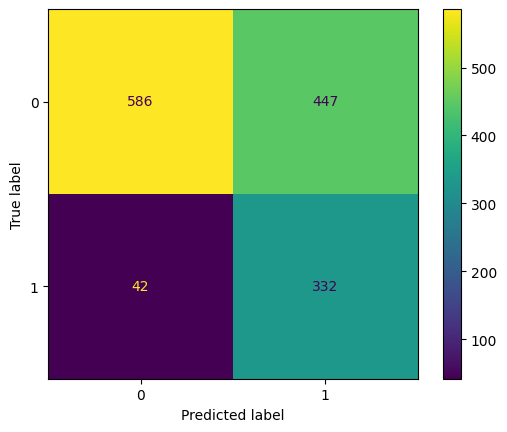

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_model_ADA.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model_ADA.classes_)
plt.figure(figsize=(8,18))
disp.plot()

plt.show()

Since the main objective of this project is to detect the as much Churn clients as possible, Recall was used to guide the hyperparameter optimization process.

Thus, the system achieved an 89% Recall rate on the test dataset.

Furthermore, although this result impaired the precision of the model, the overall F1-Score was 57%, just a bit worse than most baseline models. During the tests, no model achieved F1-Score higher than 63% even after hyperparameter optimization.

Some additional notes:

* The usage of Bayesian Search for hyperparameter optimization considerably reduced the amount of time spent os method's analysis.
* For the sake of organization, I decided to remove additional tests with other methods from this file, since they achieved inferior outcomes.
* Furthermore, I've investigated if a semi-supervised approach (clustering the data before applying to classifiers) would benefit the model. It did not. Even after using tSNE or PCA, the data visualization remained grouped, which shows that the data does could not be clusterized by k-means, BDSCAN or Mean-Shift methods.


## Saving the model

In [48]:
save_model(best_model_ADA, 'ada_classifier')

Model sklearn saved:  ada_classifier
